In [1]:
import glob
import matplotlib.image as mpimg
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
import logging
from scipy import ndimage as ndi
from scipy import signal
import pywt
from scipy.fftpack import fft2, ifft2
from skimage import feature, transform, registration
from skimage.feature import blob_log, blob_dog
from scipy.signal import fftconvolve
import matplotlib

In [2]:
# Create dictionary for IB images, sort by grid position, field with (img stack), and corresponding name/img position
dict1 = {}
dict2 = {}
dict3 = {}
grid_poses = ["000.000", "000.001", "000.002", "001.000", "001.001", "001.002", "002.000", "002.001", "002.002"]
hfws = ["8", "15", "20", "30", "50"]
names = ["base", "diag_down", "diag_up", "start"]
for grid_pos in grid_poses:
    dict1[grid_pos] = {}
    dict2[grid_pos] = {}
    for hfw in hfws:
        dict1[grid_pos][hfw] = {}
        dict2[grid_pos][hfw] = {}
        for name in names:
            fname1 = glob.glob(f"../../mapping_2022-09-27.01-18-18PM/{grid_pos}/{name}*{hfw}*.tif")[0]
            fname2 = glob.glob(f"../../mapping_2022-09-27.02-59-50PM/{grid_pos}/{name}*{hfw}*.tif")[0]
            img1 = mpimg.imread(fname1)
            img2 = mpimg.imread(fname2)
            dict1[grid_pos][hfw][name] = img1
            dict2[grid_pos][hfw][name] = img2
for grid_pos in ["000.000", "000.001", "001.000", "001.001"]:
    dict3[grid_pos] = {}
    for hfw in hfws:
        dict3[grid_pos][hfw] = {}
        for name in names:
            fname3 = glob.glob(f"../../mapping_2022-09-27.04-26-12PM/{grid_pos}/{name}*{hfw}*.tif")[0]
            img3 = mpimg.imread(fname3)
            dict3[grid_pos][hfw][name] = img3
# Create dictionary for Fluorescence images, sort by grid position (tile) and exposure times
# Additionally, transpose and crop the image array to the right IB image size.
fluor1 = {}
fluor2 = {}
fluor3 = {}
tiles = ["0.0", "0.1", "0.2", "1.0", "1.1", "1.2", "2.0", "2.1", "2.2"]
exposures = ["350", "500"]
for tile in tiles:
    fluor1[tile] = {}
    fluor2[tile] = {}
    for exposure in exposures:
        file1 = glob.glob(f"../../mapping_2022-09-27.01-18-18PM/fluro/{tile}*{exposure}*.tiff")[0]
        file2 = glob.glob(f"../../mapping_2022-09-27.02-59-50PM/fluro/{tile}*{exposure}*.tiff")[0]
        img1 = mpimg.imread(file1)
        img2 = mpimg.imread(file2)
        # Flip Vertical and crop to (1024,1536) same size as IB
        temp1 = np.flip(img1[512:1536, 256:1792], axis=0)
        temp2 = np.flip(img2[512:1536, 256:1792], axis=0)
        temp1_fft = np.fft.fftshift(np.fft.fft2(temp1))
        temp2_fft = np.fft.fftshift(np.fft.fft2(temp2))
        # New array to adjust for same pixelsize in both images!
        # Create array of dimension (x,y)/pixelratio with pixelratio here ~1.053
        mat1 = np.ndarray((972, 1458), dtype=np.complex128)
        mat2 = np.ndarray((972, 1458), dtype=np.complex128)
        # Create new array and crop s.t. middle point (highest value and 0 imaginary part) is preserved
        # Here x: 1024 -> 972 and y: 1536 -> 1458 meaning 52/2 and 78/2 respectively less at each edge
        mat1[:,:] = temp1_fft[26:26+972, 39:39+1458]
        mat2[:,:] = temp2_fft[26:26+972, 39:39+1458]
        fluor1[tile][exposure] =  np.abs(np.fft.ifft2(np.fft.ifftshift(mat1)))
        fluor2[tile][exposure] =  np.abs(np.fft.ifft2(np.fft.ifftshift(mat2)))
for tile in ["0.0", "0.1", "1.0", "1.1"]:
    fluor3[tile] = {}
    for exposure in exposures:
        file3 = glob.glob(f"../../mapping_2022-09-27.04-26-12PM/fluro/{tile}*{exposure}*.tiff")[0]
        img3 = mpimg.imread(file3)
        temp3 = np.flip(img3[512:1536, 256:1792], axis=0)
        temp3_fft = np.fft.fftshift(np.fft.fft2(temp3))
        mat3 = np.ndarray((972, 1458), dtype=np.complex128)
        mat3[:,:] = temp3_fft[26:26+972, 39:39+1458]
        fluor3[tile][exposure] = np.abs(np.fft.ifft2(np.fft.ifftshift(mat3)))

In [3]:
def bp_mask(image_shape: tuple,
                 bandpass_outer_radius: int,
                 bandpass_inner_radius: int = 0,
                 bandpass_sigma: float = None):

    bandpass_mask = np.zeros(image_shape)
    r, c = np.array(image_shape) / 2
    inner_circle_rr, inner_circle_cc = skimage.draw.disk(
        (r, c), bandpass_inner_radius, shape=image_shape)
    outer_circle_rr, outer_circle_cc = skimage.draw.disk(
        (r, c), bandpass_outer_radius, shape=image_shape)
    bandpass_mask[outer_circle_rr, outer_circle_cc] = 1.0
    bandpass_mask[inner_circle_rr, inner_circle_cc] = 0.0
    bandpass_mask = np.array(bandpass_mask)
    # fourier space origin should be in the corner
    bandpass_mask = np.roll(bandpass_mask,
                            (np.array(image_shape) / 2).astype(int),
                            axis=(0, 1))
    # Soft edges help avoid ringing artifacts in results
    if bandpass_sigma is not None:
        bandpass_mask = skimage.filters.gaussian(bandpass_mask.astype(float),
                                                 sigma=bandpass_sigma)
    return bandpass_mask

def normalize(image:np.ndarray) -> np.ndarray:
    mean, std = cv2.meanStdDev(image)
    norm = (image - mean) / std
    # zero_array = np.zeros(norm.shape)
    # final_img = cv2.normalize(norm,  zero_array, 0, 1, cv2.NORM_MINMAX)
    return norm

# radial spectrum of fourier space
def radial_spec(image: np.array):
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    R = np.sqrt(x ** 2 + y ** 2)
    f = lambda r: image[(R >= r - .5) & (R < r + .5)].mean()
    r = np.linspace(0, 824, num = 824)
    mean = np.vectorize(f)(r)
    return r, mean

In [4]:
def xcorr(
    img1: np.ndarray, 
    img2: np.ndarray,
    hp: float=None,
    lp: float=None,
    sigma: float=None) -> np.ndarray:

    if img1.data.shape != img2.data.shape:
        err = f"Image 1 {img1.data.shape} and Image 2 {img2.data.shape} need to have the same shape"
        logging.error(err)
        raise ValueError(err)

    # Create Fourier transform
    img1fft = np.fft.fftn(img1.data)
    img2fft = np.fft.fftn(img2.data)
    # Do some shady normalization
    n_pixels1 = img1.data.shape[0] * img1.data.shape[1]
    img1fft[0, 0] = 0
    tmp = img1fft * np. conj(img1fft)
    img1fft = n_pixels1 * img1fft / np.sqrt(tmp.sum())
    n_pixels2 = img2.data.shape[0] * img2.data.shape[1]
    img2fft[0, 0] = 0
    tmp = img2fft * np. conj(img2fft)
    img2fft = n_pixels2 * img2fft / np.sqrt(tmp.sum())

    corr_mask = bp_mask(img1.shape, 70, 0, 0)

    if hp and lp and sigma is not None:
        bp = bp_mask(img1.shape, hp, lp, sigma)
        
        # Cross-correlate the two images
        temp = np.real(np.fft.ifftn((img1fft * bp) * np.conj(img2fft)))
        corr = np.fft.fftshift(temp * corr_mask)
        # Cross-correlation center and shift from center
        maxX, maxY = np.unravel_index(np.argmax(corr), corr.shape)
        cen = np.asarray(corr.shape) / 2
        err = np.array(cen - [maxX, maxY], int)
        valMax = np.amax(corr)
        return corr, err

    else:

        # Cross-correlate the two images
        temp = np.real(np.fft.ifftn((img1fft * np.conj(img2fft))))
        corr = np.fft.fftshift(temp * corr_mask)

        # Cross-correlation center and shift from center
        maxX, maxY = np.unravel_index(np.argmax(corr), corr.shape)
        cen = np.asarray(corr.shape) / 2
        err = np.array(cen - [maxX, maxY], int)
        valMax = np.amax(corr)
        return corr, err

In [5]:
ib_img = []
fl_350 = []
fl_500 = []
for i, j in zip(grid_poses, tiles):
    ib2 = dict2[i]["50"]["start"][26:998, 39:1497]
    fl2 = fluor2[j]["350"]
    fl500 = fluor2[j]["500"]
    ib_img.append(ib2)
    fl_350.append(fl2) 
    fl_500.append(fl500) 

for k, l in zip((["000.000", "000.001", "001.000", "001.001"]), (["0.0", "0.1", "1.0", "1.1"])):
    ib3 = dict3[k]["50"]["start"][26:998, 39:1497]
    fl3 = fluor3[l]["350"]
    fl500_2 = fluor3[l]["500"]
    ib_img.append(ib3)
    fl_350.append(fl3)
    fl_500.append(fl500_2) 

In [6]:
# create circular mask with smooth Gaussian drop-off
def circ_mask(image:np.ndarray, mask_radius:int):
    zero_array = np.zeros(image.shape)
    mask = cv2.circle(zero_array, (412, 412), mask_radius, (1, 1, 1), -1) 
    smooth_mask = ndi.gaussian_filter(mask, 5)
    masked = image * smooth_mask
    return masked

In [7]:
ion = []
fl = []
fl2 = []
for i in range(13):
    ib = normalize(ib_img[i])
    ion.append(ib)
    lm = normalize(fl_350[i])
    fl.append(lm[150:750, 350:1050])
    lm2 = normalize(fl_500[i])
    fl2.append(lm2)

In [8]:
from scipy.ndimage import gaussian_filter
light = []
for i in range(13):
    img = np.pad(fl[i], (((972 - 600) // 2, (972 - 600) // 2), ((1458 - 700) // 2, (1458 - 700) // 2)), 'constant')

    # Create a mask that contains the values of the padding
    mask = np.ones_like(img)
    mask[:((972 - 600) // 2), :] = 0
    mask[-((972 - 600) // 2):, :] = 0
    mask[:, :((1458 - 700) // 2)] = 0
    mask[:, -((1458 - 700) // 2):] = 0

    # Use a Gaussian filter to smooth the transition between the original image and the padding
    mask = gaussian_filter(mask, sigma=10, mode='constant')

    # Apply the mask to the image, so that the transition between the original image and the padding is smoothed
    image = img * mask
        
    light.append(image)

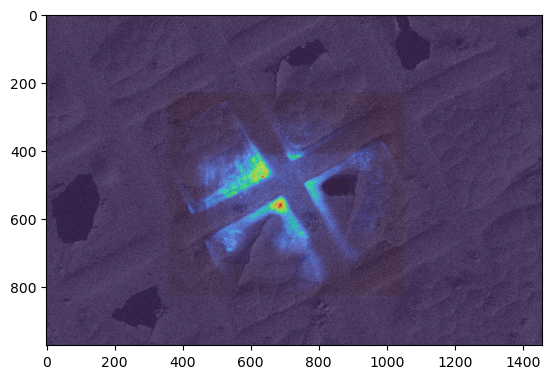

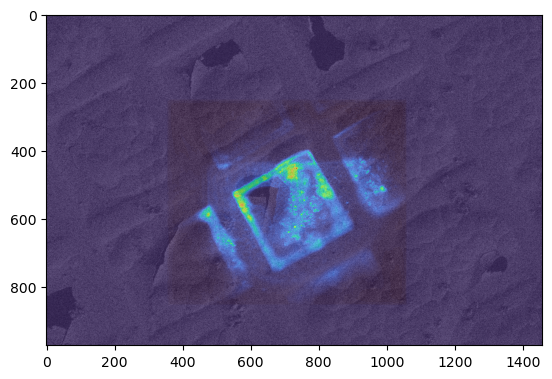

In [24]:
img1 = ion[1]
img2 = light[1]
img1 = img1.astype(np.float32)
img2 = img2.astype(np.float32)

for i in range(3):
    # Calculate the cross-correlation between the two images
    corr_mask = bp_mask(img1.shape, 70, 0, 0)

    temp = np.fft.ifftn(np.fft.fftn(ion[i]) * np.conj(np.fft.fftn(light[i])))
    corr = np.fft.fftshift(temp * corr_mask * bp_mask(temp.shape, 200, 10, 10))

    # Find the coordinates of the maximum peak in the correlation matrix
    max_loc = np.unravel_index(np.argmax(corr), corr.shape)

    # Calculate the shift as the difference between the maximum peak and the center of the correlation matrix
    shift_x = max_loc[0] - (corr.shape[0] // 2)
    shift_y = max_loc[1] - (corr.shape[1] // 2)

    img2_aligned = np.roll(light[i], (-shift_x, -shift_y), axis=(1,0))


    plt.imshow(ion[i], cmap='gray', alpha=1)
    plt.imshow(img2_aligned, cmap='turbo', alpha=0.7)
    plt.show()


err1=[-25  42]


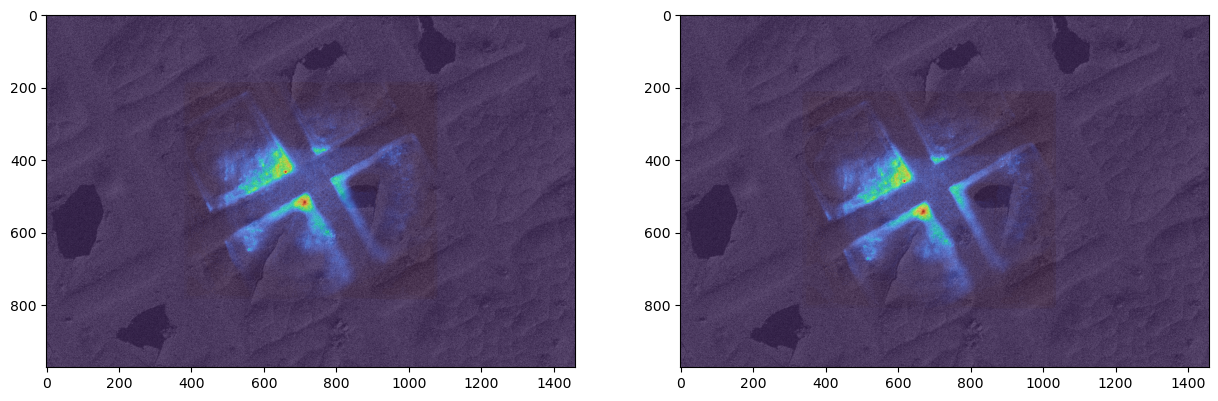

err1=[-20  67]


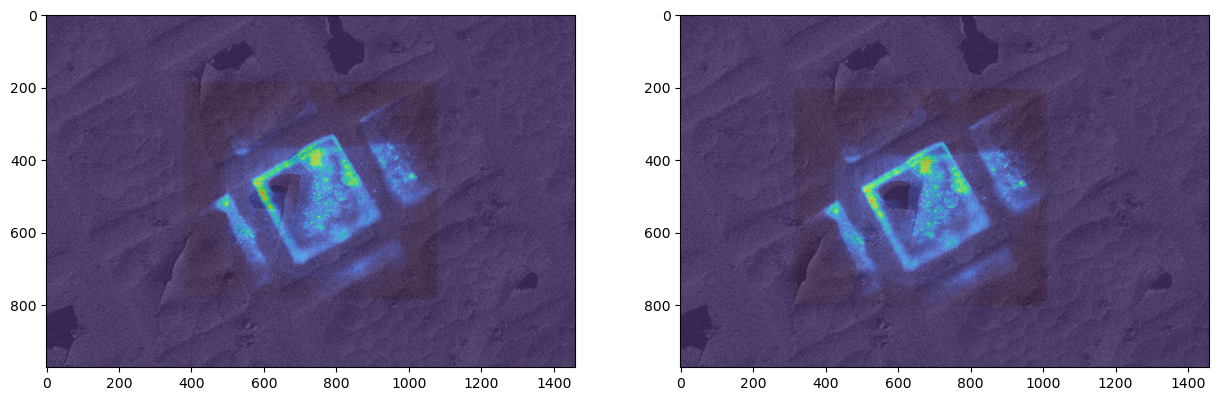

err1=[-55 -43]


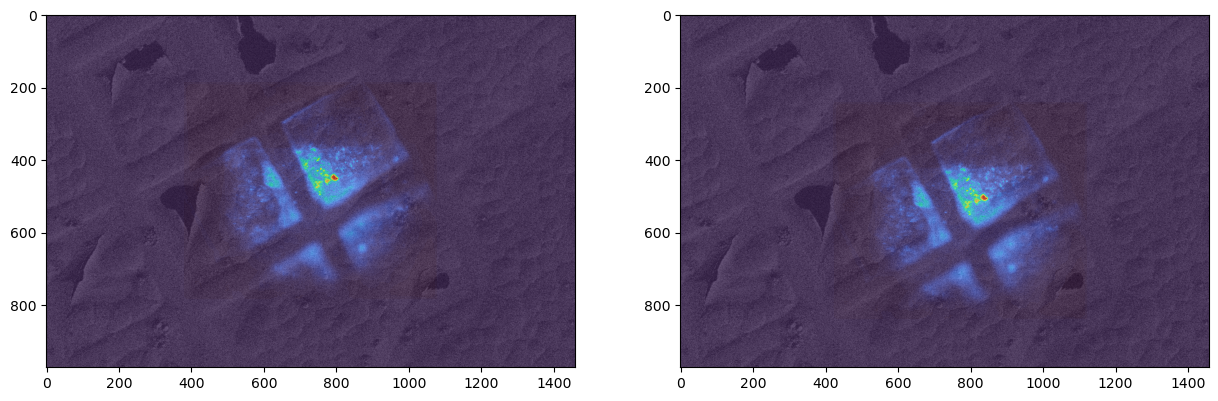

err1=[-40  23]


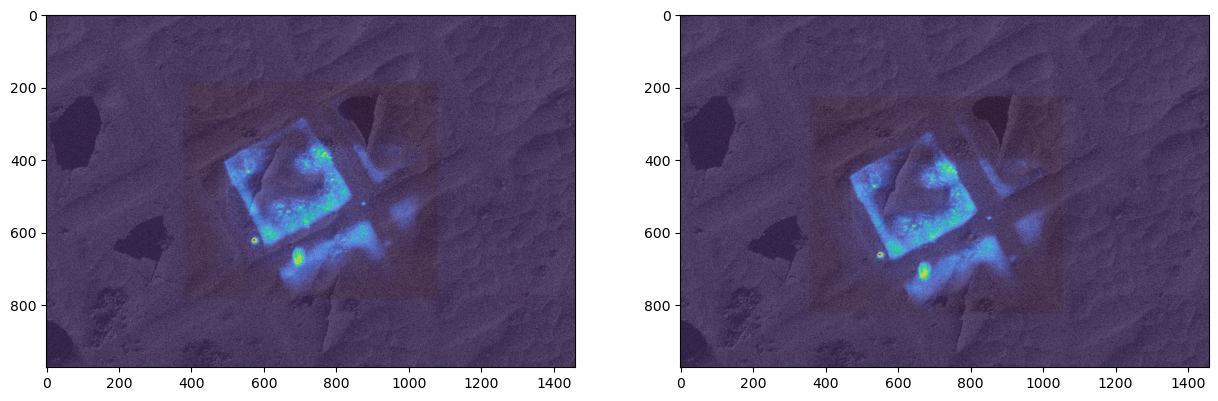

err1=[-34  56]


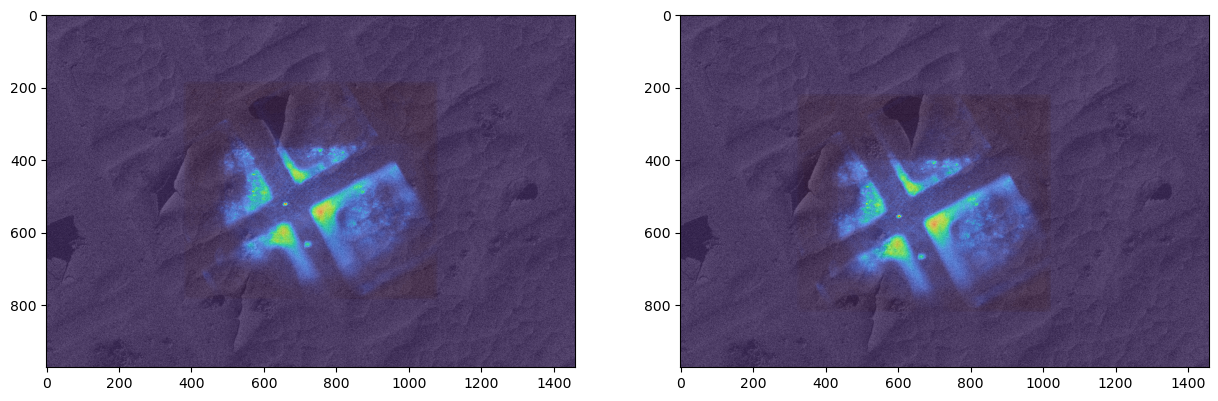

err1=[-16  68]


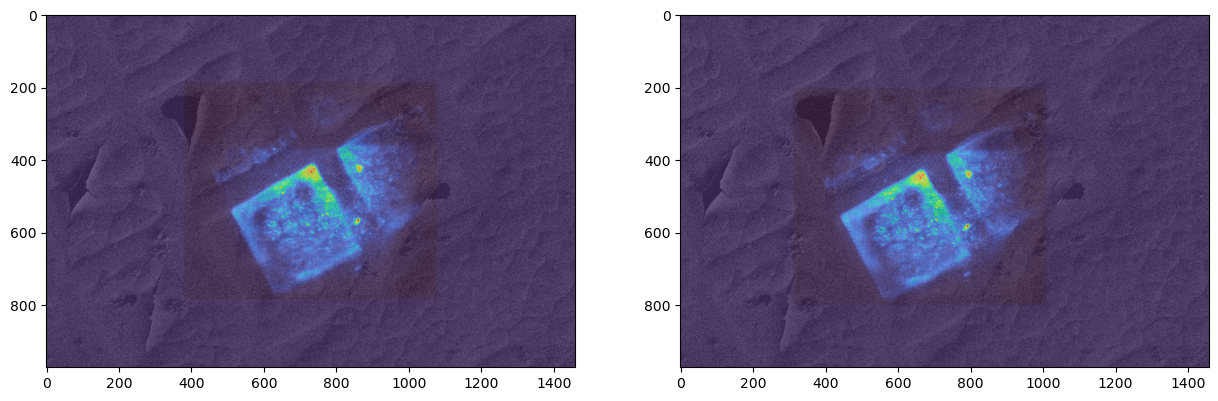

err1=[ 49 -49]


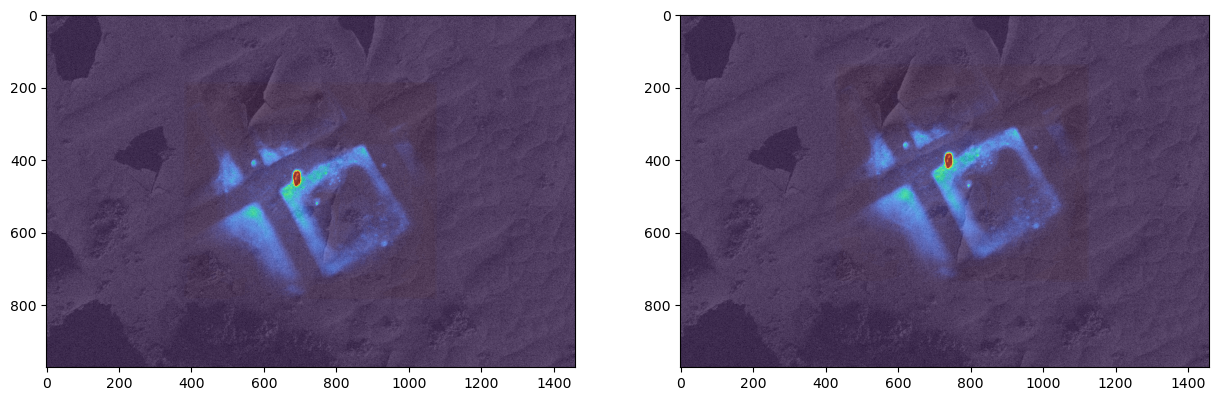

err1=[ -7 -53]


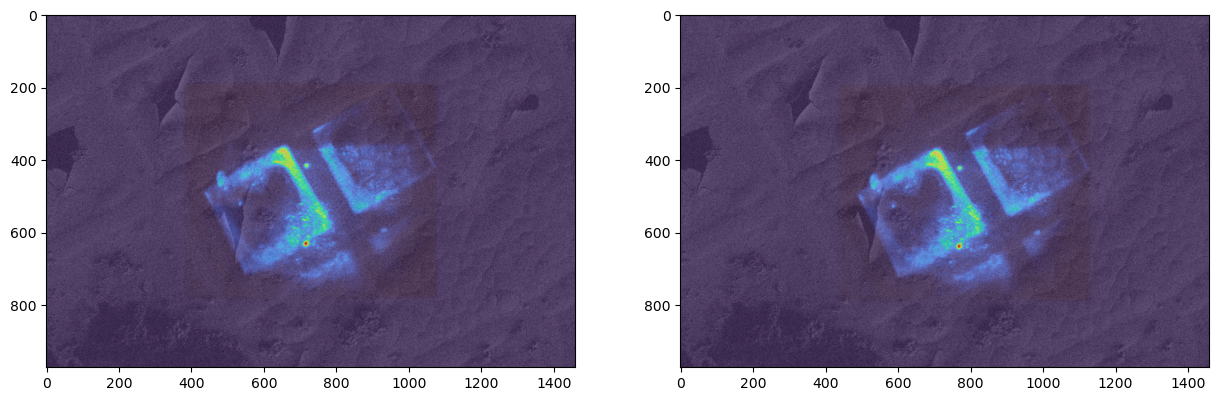

err1=[ -9 -18]


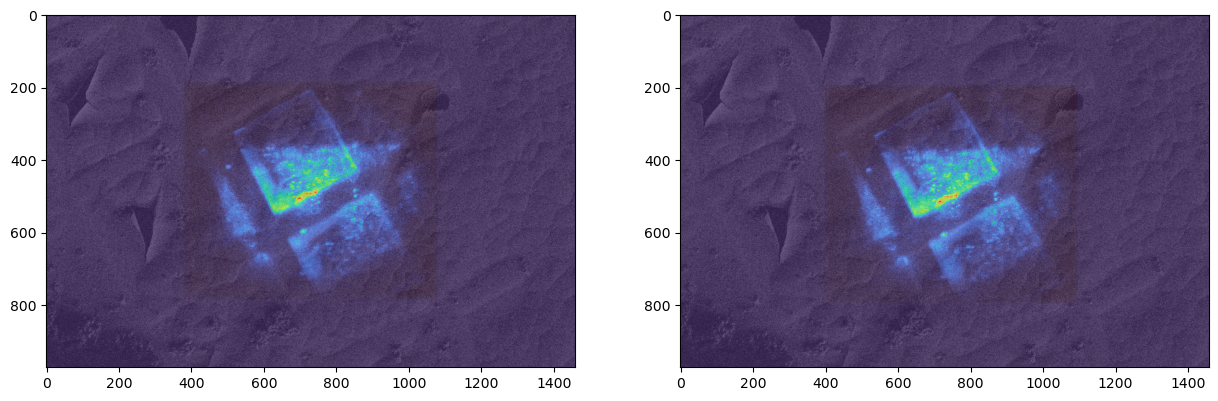

err1=[-58 -39]


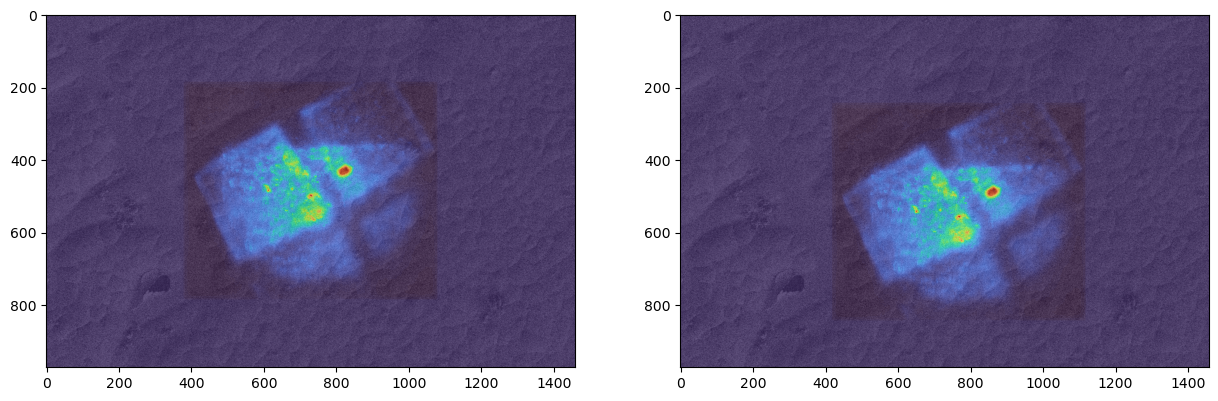

err1=[-64  17]


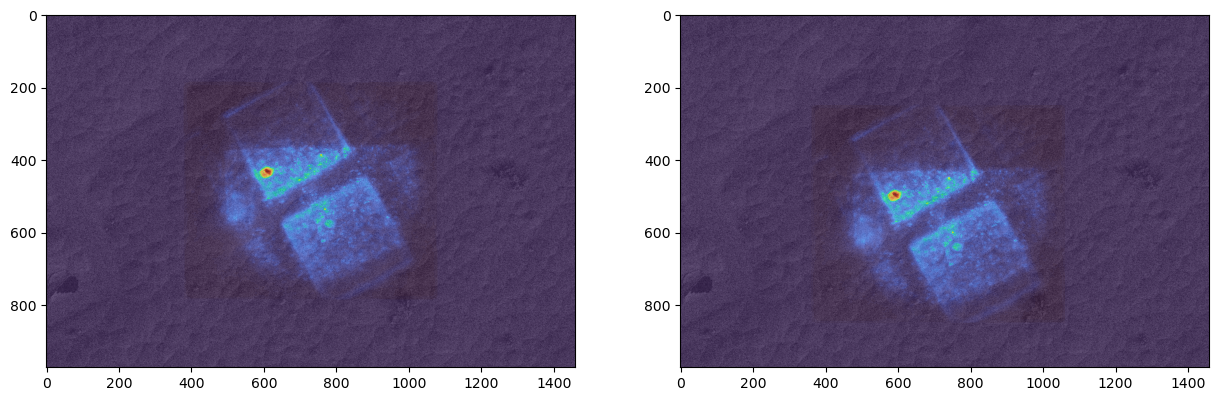

err1=[ 65 -25]


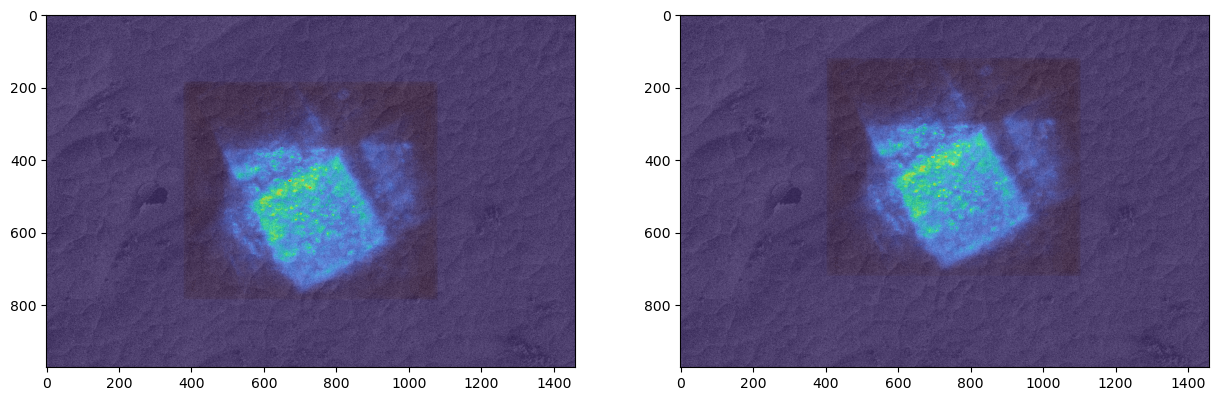

err1=[13 18]


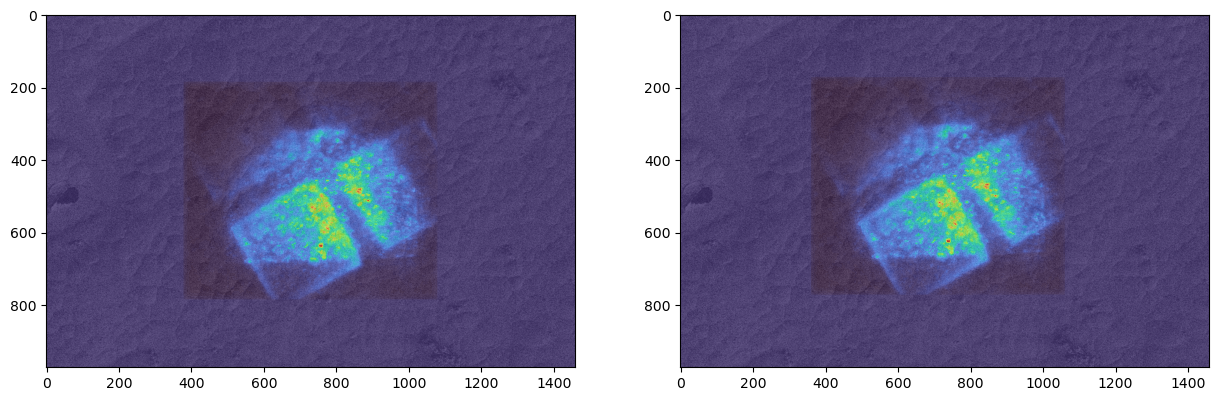

In [10]:
for i in range(13):
    corr1, err1 = xcorr(ion[i], light[i], 200, 10, 5)
    print(f"err1={err1}")
    fig, ax = plt.subplots(1,2,figsize=(15,15))
    ax[0].imshow(ion[i], cmap='gray', alpha=1)
    ax[0].imshow(light[i], cmap='turbo', alpha=0.7)
    ax[1].imshow(ion[i], cmap='gray', alpha=1)
    ax[1].imshow(np.roll(light[i], -err1, axis=(0,1)), cmap='turbo', alpha=0.7)
    plt.show()
    